# Age Detection

## Setup

### Import Statements

In [224]:
import tensorflow as tf
from keras.preprocessing import image

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [225]:
tf.__version__

'2.15.0'

### Notebook Presentation

In [226]:
pd.options.display.float_format = '{:,.2f}'.format

### Load the Data

In [227]:
df = pd.read_csv("./dataset/age_gender.csv")

In [228]:
df.sample(5)

,age,ethnicity,gender,img_name,pixels
10932,30,3,1,20170117145238579.jpg.chip.jpg,34 26 23 22 25 47 85 134 169 185 184 186 182 1...
1915,15,0,0,20170120133307597.jpg.chip.jpg,125 136 150 157 158 162 165 167 168 171 175 17...
11158,30,2,0,20170116173409625.jpg.chip.jpg,21 24 28 32 34 38 47 52 44 64 106 123 131 69 7...
19059,54,0,1,20170117171505517.jpg.chip.jpg,15 17 16 16 18 29 39 45 55 65 72 83 92 103 109...
9557,28,0,0,20170117180529832.jpg.chip.jpg,13 17 2 0 1 59 110 184 198 202 201 201 198 194...


## Preliminary Data Exploration

### Analyzing the Data

In [229]:
df.shape

(23705, 5)

In [230]:
df.columns

Index(['age', 'ethnicity', 'gender', 'img_name', 'pixels'], dtype='object')

In [231]:
df.isna().sum()

age          0
ethnicity    0
gender       0
img_name     0
pixels       0
dtype: int64

In [232]:
df.describe()

,age,ethnicity,gender
count,"23,705.00","23,705.00","23,705.00"
mean,33.30,1.27,0.48
std,19.89,1.35,0.50
min,1.00,0.00,0.00
25%,23.00,0.00,0.00
50%,29.00,1.00,0.00
75%,45.00,2.00,1.00
max,116.00,4.00,1.00


In [233]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB


### Visualizing the Ages

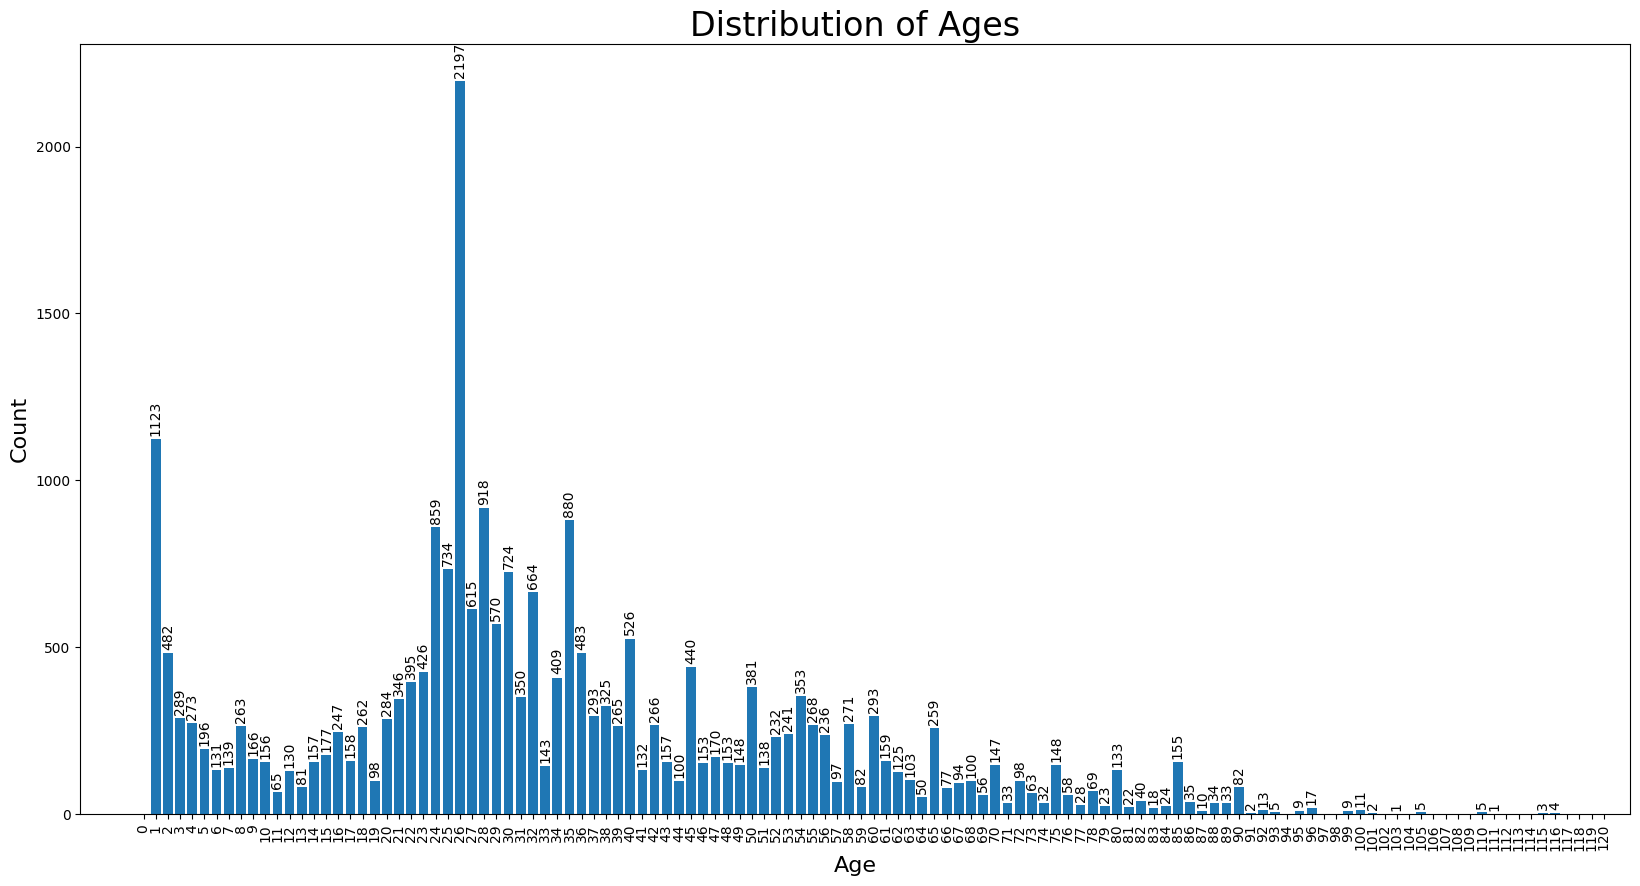

In [234]:
age_distribution = df['age'].value_counts()

plt.figure(figsize=(20, 10))
plt.bar(age_distribution.index, age_distribution.values)
plt.title("Distribution of Ages", fontsize=24)

for i, count in enumerate(age_distribution.values):
    plt.text(age_distribution.index[i], count + 10, str(count), ha='center', va='bottom', rotation=90)

plt.xticks(range(0, 121), rotation=90)
plt.xlabel('Age', fontsize=16)
plt.ylabel('Count', fontsize=16)

plt.show()

## Data Preprocessing

### Binning of the Ages

In [235]:
age_bins = [0, 5, 17, 25, 35, 45, 55, 64, 120]
age_labels = [0, 1, 2, 3, 4, 5, 6, 7]

df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=False)

In [236]:
age_group_map = ['0 - 5', '6 - 17', '18 - 25', '26 - 35', '36 - 45', '46 - 55', '56 - 64', '65+']

In [237]:
df.sample(5)

,age,ethnicity,gender,img_name,pixels,age_group
13431,35,0,0,20170117153829116.jpg.chip.jpg,28 31 38 49 69 95 116 126 129 136 143 146 148 ...,4
17008,45,0,0,20170117135112380.jpg.chip.jpg,101 49 31 34 46 52 79 109 117 118 127 131 134 ...,5
10035,29,1,0,20170116195112736.jpg.chip.jpg,72 73 73 74 76 86 94 100 100 101 101 101 103 1...,3
12364,32,0,1,20170104165148201.jpg.chip.jpg,187 193 177 139 148 119 103 99 100 105 136 145...,3
22220,73,3,0,20170119212042841.jpg.chip.jpg,156 170 183 178 161 139 120 116 119 122 141 15...,7


In [238]:
df['age_group'].unique()

[0, 1, 7, 2, 3, 4, 5, 6]
Categories (8, int64): [0 < 1 < 2 < 3 < 4 < 5 < 6 < 7]

### Visualizing the Age Ranges

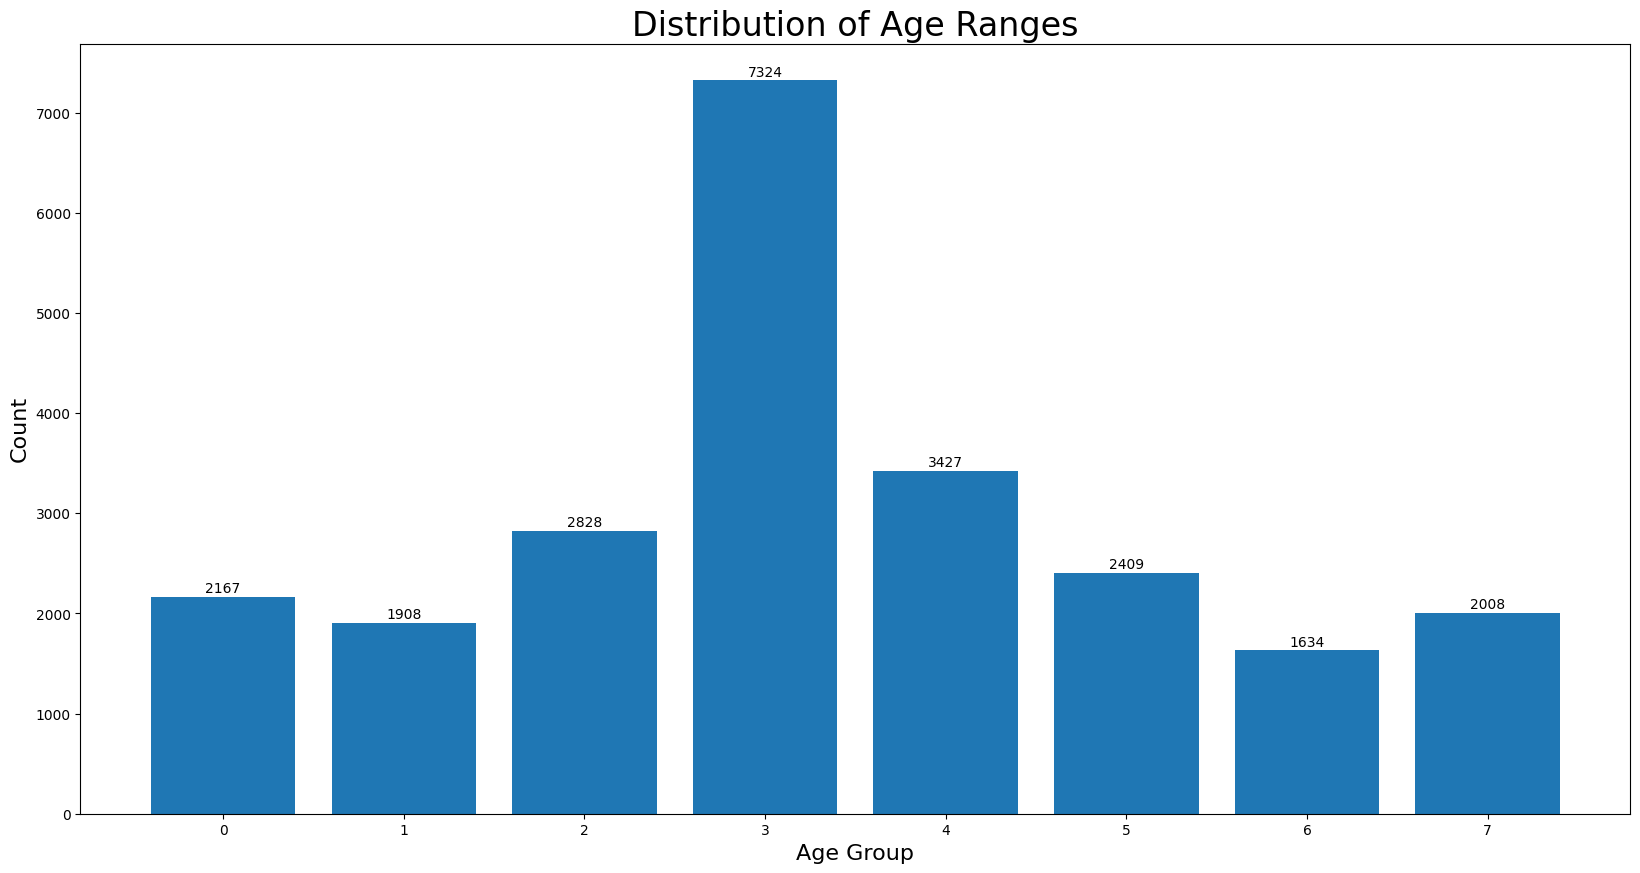

In [239]:
age_group_distribution = df['age_group'].value_counts().sort_index()

plt.figure(figsize=(20, 10))
plt.bar(age_group_distribution.index, age_group_distribution.values)
plt.title("Distribution of Age Ranges", fontsize=24)

for i, count in enumerate(age_group_distribution.values):
    plt.text(age_group_distribution.index[i], count + 10, str(count), ha='center', va='bottom')

plt.xticks(age_group_distribution.index)
plt.xlabel('Age Group', fontsize=16)
plt.ylabel('Count', fontsize=16)

plt.show()

### Reshaping the Pixels Column

In [240]:
df['pixels'] = df['pixels'].apply(lambda x:  np.array(x.split(), dtype='float32'))

df['pixels'][0]

array([129., 128., 128., ..., 146., 146., 146.], dtype=float32)

In [241]:
X = np.array(df['pixels'].tolist())

X.shape

(23705, 2304)

In [242]:
X = X.reshape(-1, 48, 48, 1) # The images are 48x48 mono

X[0].shape

(48, 48, 1)

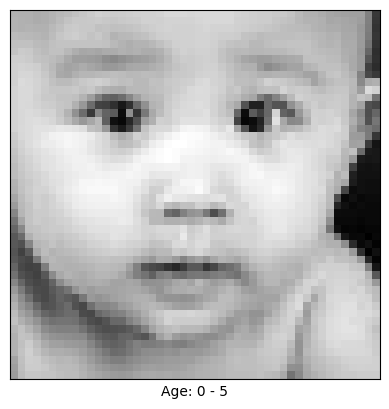

In [243]:
plt.imshow(X[0], cmap='gray')
plt.xlabel(f"Age: {age_group_map[df['age_group'][0]]}")

plt.xticks([])
plt.yticks([])
plt.grid(False)

### Training and Test Split

In [244]:
X = X / 255.0 # Normalizing the inputs
y = tf.keras.utils.to_categorical(np.array(df['age_group']), num_classes=8)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)

## The Model

### Initializing the Model

In [245]:
age_detection_model = tf.keras.models.Sequential()

### Building the Model

In [246]:
age_detection_model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(48, 48, 1)))
age_detection_model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
age_detection_model.add(tf.keras.layers.BatchNormalization())
age_detection_model.add(tf.keras.layers.Dropout(0.5))

age_detection_model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
age_detection_model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
age_detection_model.add(tf.keras.layers.BatchNormalization())
age_detection_model.add(tf.keras.layers.Dropout(0.5))

age_detection_model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu'))
age_detection_model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
age_detection_model.add(tf.keras.layers.BatchNormalization())
age_detection_model.add(tf.keras.layers.Dropout(0.5))

age_detection_model.add(tf.keras.layers.Flatten())

age_detection_model.add(tf.keras.layers.Dense(units=256, activation='relu'))
age_detection_model.add(tf.keras.layers.Dropout(0.5))

age_detection_model.add(tf.keras.layers.Dense(units=256, activation='relu'))
age_detection_model.add(tf.keras.layers.Dropout(0.5))


age_detection_model.add(tf.keras.layers.Dense(units=8, activation='softmax'))

### Compiling the Model

In [247]:
age_detection_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Training the Model

In [249]:
age_detection_model.fit(X_train, y_train, batch_size=32, validation_data=(X_test, y_test), epochs=300)

Epoch 1/300
519/519 [==============================] - 10s 20ms/step - loss: 0.9921 - accuracy: 0.5843 - val_loss: 1.0435 - val_accuracy: 0.5682
Epoch 2/300
519/519 [==============================] - 10s 19ms/step - loss: 0.9887 - accuracy: 0.5868 - val_loss: 1.2621 - val_accuracy: 0.5083
Epoch 3/300
519/519 [==============================] - 10s 19ms/step - loss: 0.9918 - accuracy: 0.5865 - val_loss: 1.2662 - val_accuracy: 0.5211
Epoch 4/300
519/519 [==============================] - 10s 19ms/step - loss: 0.9947 - accuracy: 0.5862 - val_loss: 1.0510 - val_accuracy: 0.5582
Epoch 5/300
519/519 [==============================] - 10s 20ms/step - loss: 0.9912 - accuracy: 0.5856 - val_loss: 1.0793 - val_accuracy: 0.5554
Epoch 6/300
519/519 [==============================] - 10s 20ms/step - loss: 0.9850 - accuracy: 0.5944 - val_loss: 1.1693 - val_accuracy: 0.5384
Epoch 7/300
519/519 [==============================] - 10s 20ms/step - loss: 0.9837 - accuracy: 0.5899 - val_loss: 1.2763 - val_ac

KeyboardInterrupt: 